## Package Import

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
from ta.momentum import RSIIndicator, ROCIndicator
from ta.trend import MACD
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import warnings
import joblib
from utils import *
warnings.filterwarnings('ignore')

## Random Seed Setup

In [2]:
# Set a random seed to ensure repeatable results
np.random.seed(42)
tf.random.set_seed(42)

## Data Import

In [3]:
# Load data
data_path = os.path.dirname(os.getcwd()) + '/data'
data_prefix = '/broad_assets_'

names = ['weekly_rets', 'roc_4w', 'roc_6w', 'roc_12w', 'roc_26w', 'roc_52w', 
         'bb_20d', 'bb_90d', 'bb_180d', 'bb_240d', 'macd', 'rsi', 'ht_transforms', 
         'rolling_vol_20', 'rolling_vol_60', 'rolling_vol_126', 'rolling_vol_252', 'rolling_vol_504',
         'rolling_skew_20', 'rolling_skew_60', 'rolling_skew_126', 'rolling_skew_252', 'rolling_skew_504',
         'rolling_kurt_20', 'rolling_kurt_60', 'rolling_kurt_126', 'rolling_kurt_252', 'rolling_kurt_504',
         'ewma_vol', 'skew', 'kurtosis']
dfs = {}
for name in names:
    dfs[name] = pd.read_excel(data_path + data_prefix + name + '.xlsx', sheet_name=0, index_col=0, parse_dates=True)

In [4]:
dfs['target'] = dfs.pop('weekly_rets')
dfs['target']

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2000-07-31,0.0152,0.0757,-0.0023,0.0009,0.0422,0.0050,0.0373,0.0021,-0.0025,-0.0084,-0.0318
2000-08-07,0.0679,0.0526,0.0159,0.0134,0.0365,-0.0237,-0.0196,-0.0116,0.0241,-0.0266,0.0346
2000-08-14,0.0157,0.0023,0.0152,0.0063,0.0171,0.0254,0.0294,0.0369,0.0085,0.0063,0.0481
2000-08-21,0.0095,0.0566,-0.0018,-0.0003,0.0068,-0.0264,0.0016,-0.0024,0.0077,0.0018,0.0384
2000-08-28,0.0184,0.0653,0.0019,0.0041,0.0379,-0.0353,0.0195,-0.0170,0.0019,-0.0095,0.0313
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.0607,0.0718,-0.0440,-0.0147,0.0210,0.0425,0.0431,0.0882,0.0093,0.0503,0.0583
2024-08-19,0.1006,0.1346,0.0199,-0.0004,0.1037,0.0321,0.0931,0.0771,-0.0238,0.0239,-0.0377
2024-08-26,0.0020,-0.0266,0.0028,0.0064,0.0450,0.0540,0.0290,-0.0180,-0.0195,0.0097,0.0332


In [5]:
dfs['rolling_skew_252']

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2000-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,-0.3389,-0.2707,-0.2026,-0.0170,0.2384,0.2033,-0.1006,-0.0463,-0.2407,-0.0894,-0.1624
2024-09-03,-0.3795,-0.3194,-0.2045,-0.0202,0.2046,0.1969,-0.1324,-0.0689,-0.2402,-0.0859,-0.1715
2024-09-04,-0.3743,-0.3180,-0.2194,-0.0358,0.2150,0.1950,-0.1331,-0.0614,-0.2307,-0.0875,-0.1594


## Breaking out features

### MACD

In [6]:
# MACD dataframe needs to be broken out into 3 separate dataframes
macd_names = ['MACD_Line', 'Signal_Line', 'MACD_Histogram']
for name in macd_names:
    cols = [col for col in dfs['macd'].columns if name in col]
    dfs[name] = dfs['macd'].loc[:, cols]

In [7]:
del dfs['macd']

### RSI

In [8]:
# RSI dataframe has RSI and Stochastic RSI, break these out into two frames
rsi_cols = [col for col in dfs['rsi'].columns if 'rsi' in col]
stoch_rsi_cols = [col for col in dfs['rsi'].columns if 'stoch_rsi' in col]
rsi_cols = [col for col in rsi_cols if col not in stoch_rsi_cols]   # Removing stochastic rsi column names from rsi

rsi_names = ['stoch_rsi', 'rsi']
rsi_cols = [stoch_rsi_cols, rsi_cols]

for name, cols in zip(rsi_names, rsi_cols):
    dfs[name] = dfs['rsi'].loc[:, cols]

### Bollinger Bands

In [9]:
bb_names = ['sma', 'upper', 'lower']
bb_frames = ['bb_20d', 'bb_90d', 'bb_180d', 'bb_240d']

for frame in bb_frames:
    for name in bb_names:
        cols = [col for col in dfs[frame].columns if name in col]
        dfs[f'{frame}_{name}'] = dfs[frame].loc[:, cols]

In [10]:
for frame in bb_frames:
    del dfs[frame]

### Hilbert Transforms

In [11]:
# Hilbert Transforms dataframe has five features
ht_names = ['ht_dcperiod', 'ht_dcphase', 'inphase', 'sine', 'ht_trendmode']

for name in ht_names:
    cols = [col for col in dfs['ht_transforms'].columns if name in col]
    dfs[name] = dfs['ht_transforms'].loc[:, cols]

In [12]:
del dfs['ht_transforms']

## Dates Cleanup

In [13]:
# Get intersection of dates across datasets
dates_inter = reduce(lambda x, y: set(x).intersection(y.index), list(dfs.values())[1:], list(dfs.values())[0].index)
dates_inter = sorted(list(dates_inter))
print(f'Count: {len(dates_inter)}\nFirst: {dates_inter[0]}\nLast:{dates_inter[-1]}')

Count: 1154
First: 2002-08-05 00:00:00
Last:2024-09-06 00:00:00


In [14]:
for name, frame in dfs.items():
    dfs[name] = frame.loc[dates_inter]

## Dynamic Rolling Quantile Risk Level Assignments

$$\text{Portfolio Volatility} = \sqrt{\sum^n_{i = 1}\sum^n_{j = 1}\omega_i\omega_j Cov(\sigma_i, \sigma_j)}$$
Equal weights in default.

In [15]:
def calculate_rolling_volatility(df, return_columns, window):
    """
    Calculate rolling volatility for each asset over a specified window.
    
    :param df: DataFrame containing return data
    :param return_columns: List of columns representing asset returns
    :param window: The rolling window period to calculate the volatility
    :return: DataFrame with rolling volatilities for each asset
    """
    vol_df = pd.DataFrame(index=df.index)
    
    for col in return_columns:
        # Calculate rolling standard deviation (volatility) for the given window
        vol_df[f'{col}_Vol'] = df[col].rolling(window=window).std()
    
    return vol_df.dropna()

def calculate_portfolio_volatility(df, asset_columns, window=52, weights=None):
    # Ensure the index is datetime, as 'Date' is used as the index
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df['Date'])
    
    num_assets = len(asset_columns)
    
    # Assign equal weights if no weights are provided
    if weights is None:
        weights = np.ones(num_assets) / num_assets
    
    # Ensure weights sum to 1
    weights = np.array(weights)
    if not np.isclose(weights.sum(), 1):
        raise ValueError("Weights must sum to 1.")
    
    # Covariance Matrix
    rolling_cov = df[asset_columns].rolling(window=window).cov()

    portfolio_volatility = []

    for i in range(window, len(df)):
        # Extract the covariance matrix for the current time point
        cov_matrix = rolling_cov.loc[df.index[i]].values.reshape((num_assets, num_assets))

        # Calculate the portfolio variance (weights * cov_matrix * weights.T)
        portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))

        # Calculate the portfolio volatility (square root of variance)
        portfolio_volatility.append(np.sqrt(portfolio_variance))

    portfolio_volatility_series = pd.Series(portfolio_volatility, index=df.index[window:])

    return portfolio_volatility_series

asset_columns = [col for col in dfs['ewma_vol'].columns if col.startswith('EWMA_vol_')]
rolling_window_size = 26 # Set the rolling window to be half year.

# Function to calculate rolling quantiles for volatility thresholds
def calculate_rolling_quantiles(df, asset_columns, window=13, quantiles=[0.1, 0.3, 0.7, 0.9]):
    """
    Calculate rolling quantiles for portfolio volatility over a given window.
    
    :param df: DataFrame containing volatility data
    :param asset_columns: List of columns representing asset volatilities
    :param window: Rolling window period (default is 0.5 year, assuming weekly data, i.e., 26 weeks)
    :param quantiles: Quantiles to calculate for the rolling volatility (default [0.1, 0.3, 0.7, 0.9])
    :return: DataFrame of rolling quantiles
    """
    rolling_quantiles_df = pd.DataFrame(index=df.index[window:], columns=quantiles)
    
    for i in range(window, len(df)):
        rolling_data = df.iloc[i-window:i]
        rolling_volatility = calculate_portfolio_volatility(rolling_data, asset_columns, window=13)
        rolling_quantiles = rolling_volatility.quantile(quantiles)
        rolling_quantiles_df.loc[df.index[i]] = rolling_quantiles.values

    return rolling_quantiles_df

def assign_rolling_risk_levels(vol_series, rolling_quantiles):
    risk_levels = []
    
    for i in range(len(vol_series)):
        if i >= len(rolling_quantiles):
            risk_levels.append(None)
        else:
            quantiles = rolling_quantiles.iloc[i]
            vol = vol_series.iloc[i]
            if vol > quantiles[0.9]:
                risk_levels.append('Extremely High Risk')
            elif vol > quantiles[0.7]:
                risk_levels.append('Moderately High Risk')
            elif vol > quantiles[0.3]:
                risk_levels.append('Moderately Low Risk')
            else:
                risk_levels.append('Extremely Low Risk')
    
    return pd.Series(risk_levels, index=vol_series.index)

In [16]:
ewma_weekly_vol = dfs['ewma_vol'].reset_index()
# Filter the data for the time range 2002 to 2024
period_data = ewma_weekly_vol[(ewma_weekly_vol['Date'] >= '2003-08-11') & (ewma_weekly_vol['Date'] <= '2024-12-31')]
# Calculate portfolio volatility for the test period
volatility_series = calculate_portfolio_volatility(period_data, asset_columns, window=13)
# Calculate rolling quantiles for the test period with 0.5-year rolling window
rolling_quantile_thresholds = calculate_rolling_quantiles(period_data, asset_columns, window=rolling_window_size)
# Assign risk levels for the test period using rolling quantiles
rolling_risk_levels = assign_rolling_risk_levels(volatility_series, rolling_quantile_thresholds)

In [17]:
# display(rolling_risk_levels.head(), volatility_series)
risk_levels_df = pd.DataFrame({'Portfolio Volatility': volatility_series, 'Risk Level': rolling_risk_levels})
display(risk_levels_df)

,Portfolio Volatility,Risk Level
Date,,
2003-11-10,0.0024,Moderately Low Risk
2003-11-17,0.0024,Moderately High Risk
2003-11-24,0.0024,Moderately High Risk
2003-12-01,0.0022,Moderately Low Risk
2003-12-08,0.0023,Moderately High Risk
...,...,...
2024-08-12,0.0065,None
2024-08-19,0.0070,None
2024-08-26,0.0072,None


## Features Import

### Feature adjustments based on the Generated Raw Data

In [18]:
# RSI/stoch_RSI
df_rsi = dfs['rsi']
df_rsi.columns = [f"RSI_Asset {i+1}" for i in range(len(dfs['rsi'].columns))]
df_stoch_rsi = dfs['stoch_rsi']
df_stoch_rsi.columns = [f"stoch_RSI_Asset {i+1}" for i in range(len(dfs['stoch_rsi'].columns))]
# ROC 4/6/12/26/52w
df_roc_4w = dfs['roc_4w']
df_roc_6w = dfs['roc_6w']
df_roc_12w = dfs['roc_12w']
df_roc_26w = dfs['roc_26w']
df_roc_52w = dfs['roc_52w']
# Boilinger Bands lower/sma/upper 20/90/180/240d
df_bb_20d_lower = dfs['bb_20d_lower']
df_bb_20d_sma = dfs['bb_20d_sma']
df_bb_20d_upper = dfs['bb_20d_upper']
df_bb_90d_lower = dfs['bb_90d_lower']
df_bb_90d_sma = dfs['bb_90d_sma']
df_bb_90d_upper = dfs['bb_90d_upper']
df_bb_180d_lower = dfs['bb_180d_lower']
df_bb_180d_sma = dfs['bb_180d_sma']
df_bb_180d_upper = dfs['bb_180d_upper']
df_bb_240d_lower = dfs['bb_240d_lower']
df_bb_240d_sma = dfs['bb_240d_sma']
df_bb_240d_upper = dfs['bb_240d_upper']
# MACD (macd_line, signal_line, macd_histogram)
df_macd_line = dfs['MACD_Line']
df_signal_line = dfs['Signal_Line']
df_macd_histogram = dfs['MACD_Histogram']
# Hilbert Transforms (ht_dcperiod, ht_dcphase, inphase, sine, ht_trendmode)
df_ht_dcperiod = dfs['ht_dcperiod']
df_ht_dcphase = dfs['ht_dcphase']
df_inphase = dfs['inphase']
df_sine = dfs['sine']
df_ht_trendmode = dfs['ht_trendmode']
# Rolling Volatilities (20/60/126/252/504d)
df_rolling_vol_20 = dfs['rolling_vol_20']
df_rolling_vol_60 = dfs['rolling_vol_60']
df_rolling_vol_126 = dfs['rolling_vol_126']
df_rolling_vol_252 = dfs['rolling_vol_252']
df_rolling_vol_504 = dfs['rolling_vol_504']
df_rolling_vol_20.columns = [f"rolling_vol_20_Asset {i+1}" for i in range(len(dfs['rolling_vol_20'].columns))]
df_rolling_vol_60.columns = [f"rolling_vol_60_Asset {i+1}" for i in range(len(dfs['rolling_vol_60'].columns))]
df_rolling_vol_126.columns = [f"rolling_vol_126_Asset {i+1}" for i in range(len(dfs['rolling_vol_126'].columns))]
df_rolling_vol_252.columns = [f"rolling_vol_252_Asset {i+1}" for i in range(len(dfs['rolling_vol_252'].columns))]
df_rolling_vol_504.columns = [f"rolling_vol_504_Asset {i+1}" for i in range(len(dfs['rolling_vol_504'].columns))]
# Rolling Skews (20/60/126/252/504d)
df_rolling_skew_20 = dfs['rolling_skew_20']
df_rolling_skew_60 = dfs['rolling_skew_60']
df_rolling_skew_126 = dfs['rolling_skew_126']
df_rolling_skew_252 = dfs['rolling_skew_252']
df_rolling_skew_504 = dfs['rolling_skew_504']
df_rolling_skew_20.columns = [f"rolling_skew_20_Asset {i+1}" for i in range(len(dfs['rolling_skew_20'].columns))]
df_rolling_skew_60.columns = [f"rolling_skew_60_Asset {i+1}" for i in range(len(dfs['rolling_skew_60'].columns))]
df_rolling_skew_126.columns = [f"rolling_skew_126_Asset {i+1}" for i in range(len(dfs['rolling_skew_126'].columns))]
df_rolling_skew_252.columns = [f"rolling_skew_252_Asset {i+1}" for i in range(len(dfs['rolling_skew_252'].columns))]
df_rolling_skew_504.columns = [f"rolling_skew_504_Asset {i+1}" for i in range(len(dfs['rolling_skew_504'].columns))]
# Rolling Kurtosis (20/60/126/252/504d)
df_rolling_kurt_20 = dfs['rolling_kurt_20']
df_rolling_kurt_60 = dfs['rolling_kurt_60']
df_rolling_kurt_126 = dfs['rolling_kurt_126']
df_rolling_kurt_252 = dfs['rolling_kurt_252']
df_rolling_kurt_504 = dfs['rolling_kurt_504']
df_rolling_kurt_20.columns = [f"rolling_kurtosis_20_Asset {i+1}" for i in range(len(dfs['rolling_kurt_20'].columns))]
df_rolling_kurt_60.columns = [f"rolling_kurtosis_60_Asset {i+1}" for i in range(len(dfs['rolling_kurt_60'].columns))]
df_rolling_kurt_126.columns = [f"rolling_kurtosis_126_Asset {i+1}" for i in range(len(dfs['rolling_kurt_126'].columns))]
df_rolling_kurt_252.columns = [f"rolling_kurtosis_252_Asset {i+1}" for i in range(len(dfs['rolling_kurt_252'].columns))]
df_rolling_kurt_504.columns = [f"rolling_kurtosis_504_Asset {i+1}" for i in range(len(dfs['rolling_kurt_504'].columns))]
# EWMA VOL
df_vol = dfs['ewma_vol']
# Skew
df_skew = dfs['skew']
df_skew.columns = [f"SKEW_Asset {i+1}" for i in range(len(dfs['skew'].columns))]
# Kurtosis
df_kurtosis = dfs['kurtosis']
df_kurtosis.columns = [f"KURTOSIS_Asset {i+1}" for i in range(len(dfs['kurtosis'].columns))]

### Features Wrapping Up

In [19]:
# Features: RSI, ROC, MACD, EWMA, SKEW, KURTOSIS
# ROC 4/6/12/26/52w
# Boilinger Bands lower/sma/upper 20/90/180/240d
# MACD (macd_line, signal_line, macd_histogram)
# Hilbert Transforms (ht_dcperiod, ht_dcphase, inphase, sine, ht_trendmode)
# Rolling Volatilities (20/60/126/252/504d)
combined_df = pd.concat([df_rsi, df_stoch_rsi, df_roc_4w, df_roc_6w, df_roc_12w, df_roc_26w, df_roc_52w, 
                         df_bb_20d_lower, df_bb_20d_sma, df_bb_20d_upper, df_bb_90d_lower, df_bb_90d_sma, df_bb_90d_upper,
                         df_bb_180d_lower, df_bb_180d_sma, df_bb_180d_upper, df_bb_240d_lower, df_bb_240d_sma, df_bb_240d_upper,
                         df_macd_line, df_signal_line, df_macd_histogram, df_ht_dcperiod, df_ht_dcphase, df_inphase, df_sine,
                         df_ht_trendmode, df_rolling_vol_20, df_rolling_vol_60, df_rolling_vol_126, df_rolling_vol_252, df_rolling_vol_504,
                         df_rolling_skew_20, df_rolling_skew_60, df_rolling_skew_126, df_rolling_skew_252, df_rolling_skew_504,
                         df_rolling_kurt_20, df_rolling_kurt_60, df_rolling_kurt_126, df_rolling_kurt_252, df_rolling_kurt_504,
                         df_vol, df_skew, df_kurtosis], axis=1)
metrics_order = ["RSI", "stoch_RSI", "ROC4", "ROC6", "ROC12", "ROC26", "ROC52", "lower20", "sma20", "upper20", 
                 "lower90", "sma90", "upper90", "lower180", "sma180", "upper180", "lower240", "sma240", "upper240",
                 "MACD_Line", "Signal_Line", "MACD_Histogram", "ht_dcperiod", "ht_dcphase", "inphase", "sine", "ht_trendmode",
                 "rolling_vol_20", "rolling_vol_60", "rolling_vol_126", "rolling_vol_252", "rolling_vol_504",
                 "rolling_skew_20", "rolling_skew_60", "rolling_skew_126", "rolling_skew_252", "rolling_skew_504",
                 "rolling_kurtosis_20", "rolling_kurtosis_60", "rolling_kurtosis_126", "rolling_kurtosis_252", "rolling_kurtosis_504",
                 "EWMA_vol", "SKEW", "KURTOSIS"]
# Extract unique asset numbers and metrics from the column names
unique_assets = sorted(set(int(col.split()[-1]) for col in combined_df.columns))
# Generate the correctly ordered columns for each asset by grouping them directly
ordered_columns = [f"{metric}_Asset {asset}" for asset in unique_assets for metric in metrics_order]
# Select only the columns that exist in the data
valid_columns = [col for col in ordered_columns if col in combined_df.columns]
# Reorder the dataframe columns based on this direct, valid list
features = combined_df[valid_columns].dropna()

final_df = pd.concat([features, risk_levels_df], axis = 1)
final_df = final_df.dropna()
final_df

,RSI_Asset 1,stoch_RSI_Asset 1,ROC4_Asset 1,ROC6_Asset 1,ROC12_Asset 1,ROC26_Asset 1,ROC52_Asset 1,lower20_Asset 1,sma20_Asset 1,upper20_Asset 1,...,rolling_kurtosis_20_Asset 11,rolling_kurtosis_60_Asset 11,rolling_kurtosis_126_Asset 11,rolling_kurtosis_252_Asset 11,rolling_kurtosis_504_Asset 11,EWMA_vol_Asset 11,SKEW_Asset 11,KURTOSIS_Asset 11,Portfolio Volatility,Risk Level
Date,,,,,,,,,,,,,,,,,,,,,
2003-11-10,51.4365,0.3680,0.0044,0.0834,0.0986,0.2301,0.4155,-0.0265,0.0003,0.0271,...,4.6978,3.5043,1.4362,0.6524,0.6612,0.0533,-0.2921,1.2053,0.0024,Moderately Low Risk
2003-11-17,48.7950,0.0000,-0.0004,0.0204,0.1054,0.2878,0.3323,-0.0278,0.0001,0.0280,...,3.2259,3.0690,1.4965,0.6351,0.4919,0.0499,-0.2969,1.2111,0.0024,Moderately High Risk
2003-11-24,50.1757,0.3899,0.0427,0.0143,0.0910,0.2738,0.2618,-0.0285,0.0022,0.0330,...,1.1303,2.0971,1.4780,0.5747,0.4799,0.0654,-0.2973,1.1786,0.0024,Moderately High Risk
2003-12-01,63.1201,0.7460,0.0226,0.0510,0.0777,0.2281,0.3023,-0.0275,0.0020,0.0315,...,1.1341,2.0946,1.6244,0.5856,0.4939,0.0605,-0.3010,1.1857,0.0022,Moderately Low Risk
2003-12-08,64.7689,1.0000,0.0441,0.0780,0.1122,0.2042,0.4284,-0.0279,0.0017,0.0312,...,0.9591,1.4852,1.5612,0.5102,0.5090,0.0645,-0.2948,1.1694,0.0023,Moderately High Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-13,68.5255,0.8488,0.0598,-0.0144,0.0769,0.3747,0.5327,-0.0269,0.0030,0.0329,...,0.7232,0.4486,0.3787,0.6037,2.4291,0.0343,-0.3321,3.1927,0.0030,Extremely High Risk
2024-05-20,90.7375,1.0000,0.1191,0.0360,0.0864,0.3373,0.5422,-0.0220,0.0057,0.0335,...,0.8901,0.3895,0.1518,0.6927,2.5387,0.0350,-0.3327,3.1951,0.0028,Moderately High Risk
2024-05-24,73.9980,0.2751,0.0724,0.0931,0.0587,0.3336,0.5311,-0.0230,0.0039,0.0307,...,-0.4642,0.1913,0.1255,0.6703,2.5024,0.0365,-0.3322,3.1954,0.0028,Moderately Low Risk


In [20]:
df_target = dfs['target'].loc[final_df.index]  # Adjust the original returns data aligning with the final features data

1. Use previous 20-week returns to predict the next week return.
2. Target variables are converted to binary: 1 for positive returns and 0 for negative returuns.
3. Training & Testing dataset split: 80\% for training and 20\% for testing.

In [21]:
sequence_length = 20
models = {}
scalers = {}
histories = {}
predictions = {}
binary_predictions = {}
test_dates = None  # Store the dates in the testing set

# Define the columns of features to be used for model training, excluding non-numeric or unnecessary columns
feature_columns = [col for col in final_df.columns if col not in ['Portfolio Volatility', 'Risk Level']]

def create_sequences(features, target, seq_length):
    X = []
    y = []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

In [22]:
feature_columns

['RSI_Asset 1',
 'stoch_RSI_Asset 1',
 'ROC4_Asset 1',
 'ROC6_Asset 1',
 'ROC12_Asset 1',
 'ROC26_Asset 1',
 'ROC52_Asset 1',
 'lower20_Asset 1',
 'sma20_Asset 1',
 'upper20_Asset 1',
 'lower90_Asset 1',
 'sma90_Asset 1',
 'upper90_Asset 1',
 'lower180_Asset 1',
 'sma180_Asset 1',
 'upper180_Asset 1',
 'lower240_Asset 1',
 'sma240_Asset 1',
 'upper240_Asset 1',
 'MACD_Line_Asset 1',
 'Signal_Line_Asset 1',
 'MACD_Histogram_Asset 1',
 'ht_dcperiod_Asset 1',
 'ht_dcphase_Asset 1',
 'inphase_Asset 1',
 'sine_Asset 1',
 'ht_trendmode_Asset 1',
 'rolling_vol_20_Asset 1',
 'rolling_vol_60_Asset 1',
 'rolling_vol_126_Asset 1',
 'rolling_vol_252_Asset 1',
 'rolling_vol_504_Asset 1',
 'rolling_skew_20_Asset 1',
 'rolling_skew_60_Asset 1',
 'rolling_skew_126_Asset 1',
 'rolling_skew_252_Asset 1',
 'rolling_skew_504_Asset 1',
 'rolling_kurtosis_20_Asset 1',
 'rolling_kurtosis_60_Asset 1',
 'rolling_kurtosis_126_Asset 1',
 'rolling_kurtosis_252_Asset 1',
 'rolling_kurtosis_504_Asset 1',
 'EWMA_vol

In [23]:
assets = df_target.columns[0:]
assets

Index(['Asset 1', 'Asset 2', 'Asset 3', 'Asset 4', 'Asset 5', 'Asset 6',
       'Asset 7', 'Asset 8', 'Asset 9', 'Asset 10', 'Asset 11'],
      dtype='object')

Epoch 1/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5392 - loss: 0.6898 - val_accuracy: 0.5159 - val_loss: 0.6956
Epoch 2/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5482 - loss: 0.6883 - val_accuracy: 0.5159 - val_loss: 0.6997
Epoch 3/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5506 - loss: 0.6872 - val_accuracy: 0.5159 - val_loss: 0.6970
Epoch 4/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5472 - loss: 0.6877 - val_accuracy: 0.5159 - val_loss: 0.6982
Epoch 5/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5496 - loss: 0.6874 - val_accuracy: 0.5159 - val_loss: 0.6999
Epoch 6/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5528 - loss: 0.6866 - val_accuracy: 0.5159 - val_loss: 0.6998
Epoch 7/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5471 - loss: 0.6875 - val_accuracy: 0.5159 - val_loss: 0.7006
Epoch 8/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5504 - loss: 0.6868 - val_accuracy: 0.

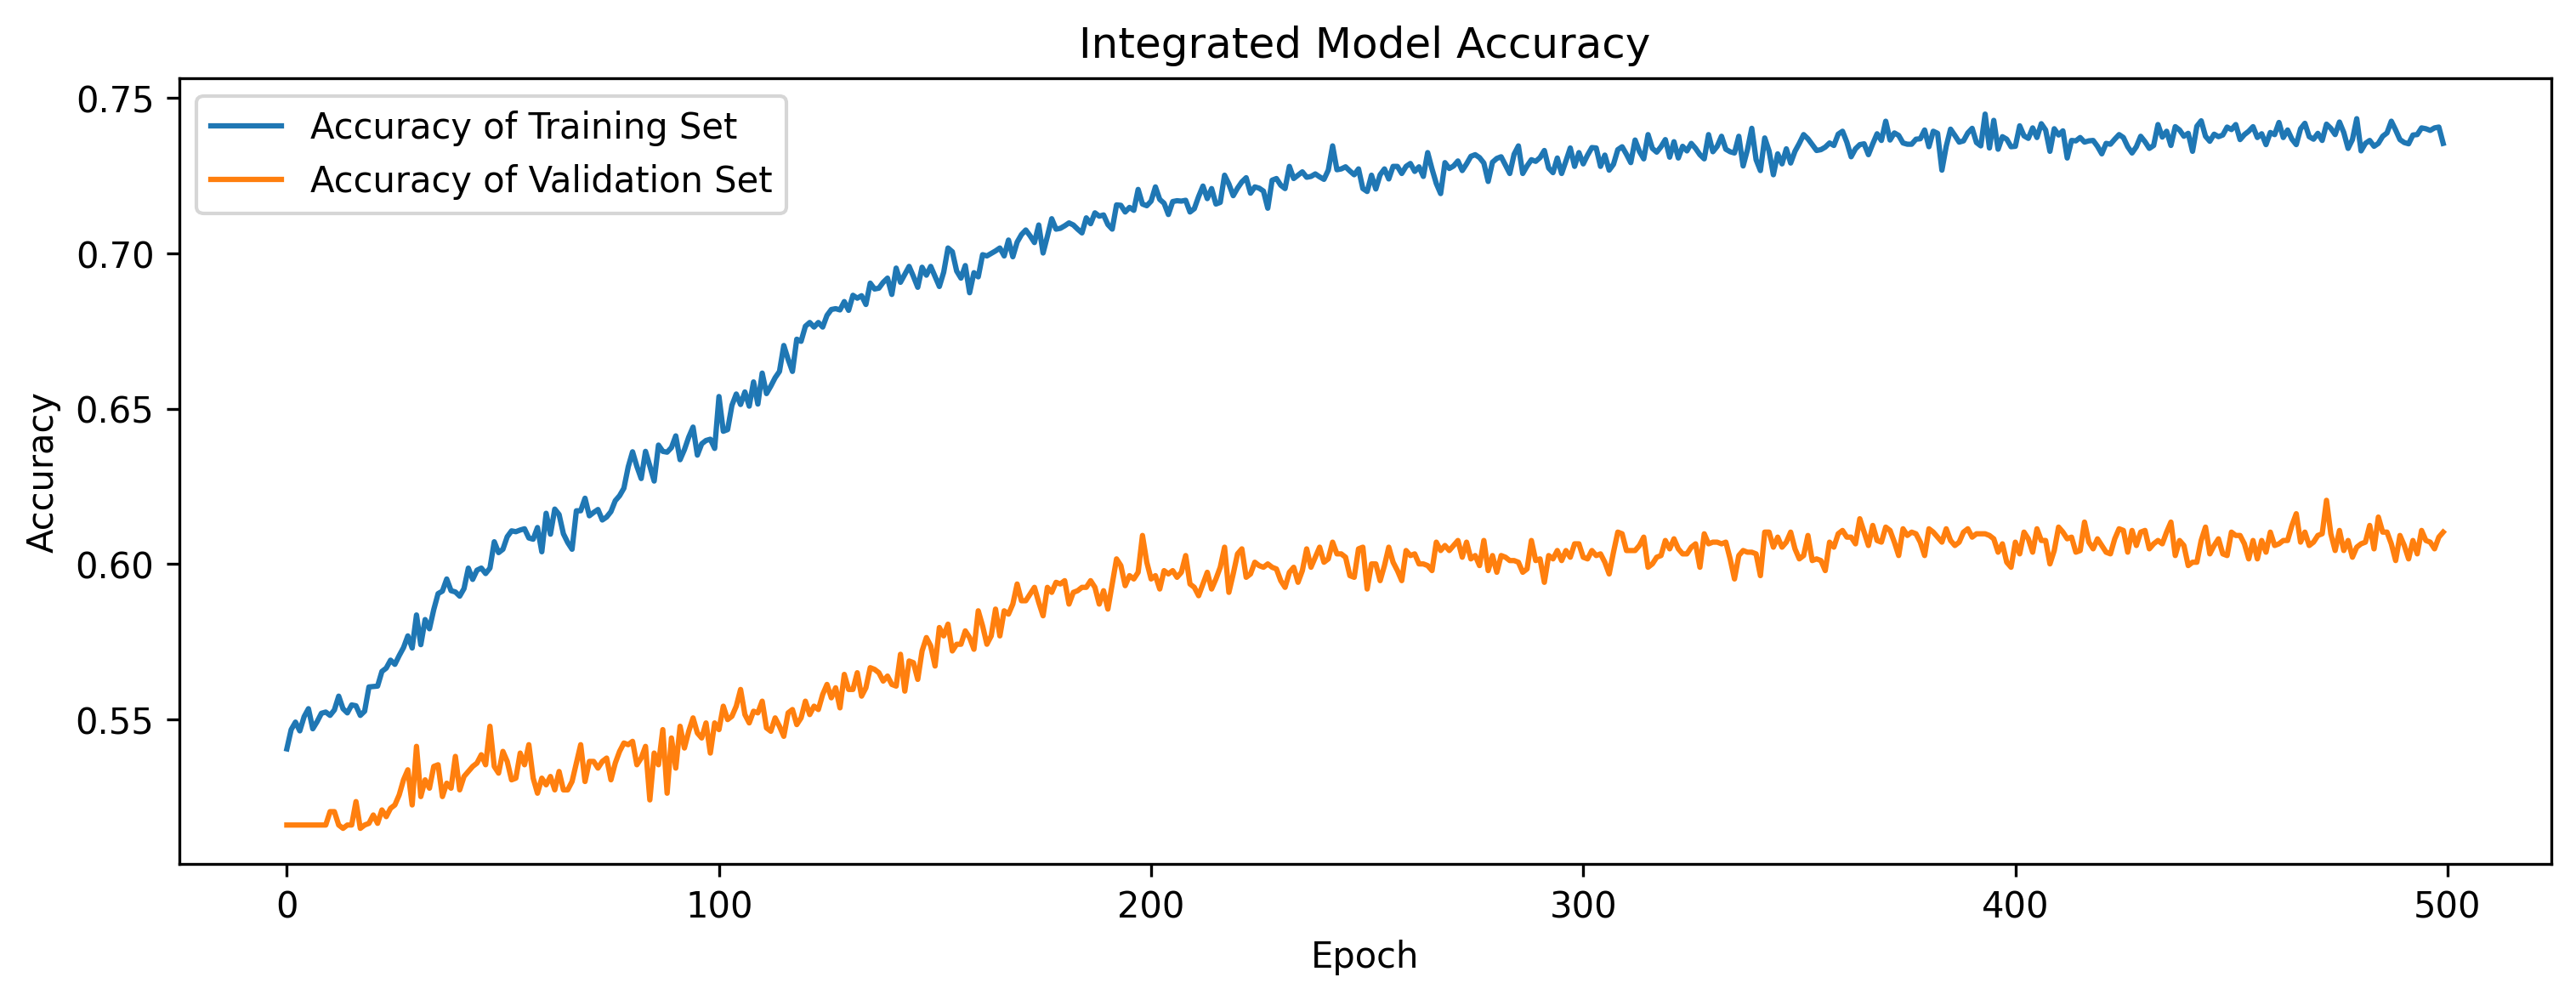

In [32]:
# Combine all features and targets for all assets into a unified dataset
all_features = []
all_targets = []

for asset in assets:
    # Define the target variable as the return for the following week
    target = df_target[asset].shift(-1).dropna()

    # Select columns that contain only numeric features
    current_features = features.loc[target.index, feature_columns]
    X, y = create_sequences(current_features.values, target.values, sequence_length)

    # Filtering NA values one more time
    valid_indices = ~np.isnan(y)
    X = X[valid_indices]
    y = y[valid_indices]

    # Target variables converted to binary: 1 for positive returns and 0 for negative returns
    y = (y > 0).astype(int)

    all_features.append(X)
    all_targets.append(y)

# Concatenate all features and targets into unified arrays
X_all = np.concatenate(all_features, axis=0)
y_all = np.concatenate(all_targets, axis=0)

# Manually split training and test sets (80% training, 20% testing)
split_index = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split_index], X_all[split_index:]
y_train, y_test = y_all[:split_index], y_all[split_index:]

# Feature scaling (normalization)
scaler = MinMaxScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

# LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Dichotomized output

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=500,  # Epochs of traing - can be adjusted manually
    batch_size=256,  # Batch size - can be adjuste manually
    validation_split=0.2,  # Ratio of the validation set
    verbose=1  # Training progress
    )

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Integrated Model - Loss of the testing set: {loss:.4f}, Accuracy: {accuracy:.4f}')

# Make predictions on the test set
pred_prob = model.predict(X_test_scaled).flatten()

# Convert probabilities to binary predictions (1 or 0)
pred_binary = (pred_prob > 0.5).astype(int)

plt.figure(figsize=(12, 4), dpi=300)
plt.plot(history.history['accuracy'], label='Accuracy of Training Set')
plt.plot(history.history['val_accuracy'], label='Accuracy of Validation Set')
plt.title('Integrated Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Asset Ranking Based on the ML Outcomes and Dynamic Risk Levels

In [33]:
display(binary_predictions['Asset 1'], binary_predictions['Asset 2'])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [34]:
test_dates

DatetimeIndex(['2020-05-22', '2020-06-01', '2020-06-08', '2020-06-15',
               '2020-06-22', '2020-06-29', '2020-07-06', '2020-07-13',
               '2020-07-20', '2020-07-27',
               ...
               '2024-04-01', '2024-04-08', '2024-04-15', '2024-04-22',
               '2024-04-29', '2024-05-06', '2024-05-13', '2024-05-20',
               '2024-05-24', '2024-06-03'],
              dtype='datetime64[ns]', name='Date', length=211, freq=None)

In [38]:
data_path = os.path.dirname(os.getcwd()) + '/data'
output_df = pd.DataFrame({'Date': test_dates})

# Add binary outputs for each asset
for asset in binary_predictions:
    output_df[asset] = binary_predictions[asset]
output_df.set_index('Date', inplace = True)
output_df.to_excel(data_path + '/broad_assets_lstm_test_data.xlsx', sheet_name='broad_assets_lstm_test')

In [31]:
# Define the risk level selection mapping
risk_level_selection = {
    'Extremely High Risk': 2,
    'Moderately High Risk': 3,
    'Moderately Low Risk': 5,
    'Extremely Low Risk': 6
}

selected_assets_per_week = {}
for i, test_date in enumerate(test_dates):
    positive_assets = []
    
    # Get the risk level for the current period (same for all assets on this date)
    final_data = final_df.reset_index()
    risk_level = final_data.loc[final_data['Date'] == test_date, 'Risk Level'].iloc[0]
    max_investments = risk_level_selection.get(risk_level, 0)  # Maximum assets allowed for this risk level
    
    # Collect assets with positive returns and retrieve their EWMA volatility
    for asset, predictions in binary_predictions.items():
        if predictions[i] == 1:  # Positive return predicted
            # Retrieve EWMA volatility for the asset on the current date
            ewma_vol_col = f'EWMA_vol_{asset}'
            ewma_vol = final_data.loc[final_data['Date'] == test_date, ewma_vol_col].iloc[0]
            
            # Add asset along with its EWMA volatility
            positive_assets.append((asset, ewma_vol))
    
    # Sort assets by EWMA volatility (low to high) to prioritize lower-volatility assets
    positive_assets.sort(key=lambda x: x[1])  # Sort by EWMA volatility (ascending)
    
    # Select up to the maximum number of assets allowed for the current risk level
    selected_assets_per_week[test_date] = [asset for asset, _ in positive_assets[:max_investments]]

# Create DataFrame for final selected assets per week
investment_details_df = pd.DataFrame([
    {"Date": date, "Investment Count": len(assets), "Assets": assets}
    for date, assets in selected_assets_per_week.items()
])

# Determine the maximum number of assets selected per week to set column limits
max_assets = max(len(assets) for assets in selected_assets_per_week.values())

# Convert selected_assets_per_week to a DataFrame with each asset in a separate column
investment_details_df = pd.DataFrame([
    {"Date": date, "Investment Count": len(assets), "Assets": assets}
    for date, assets in selected_assets_per_week.items()
])

# Create new columns for each possible asset position
for i in range(max_assets):
    investment_details_df[f"Asset_{i+1}"] = investment_details_df["Assets"].apply(lambda x: x[i] if i < len(x) else None)

# Drop the original 'Assets' list column
investment_details_df = investment_details_df.drop(columns=["Assets"])

# Rename columns to "Selected_1", "Selected_2", etc.
for i in range(1, max_assets + 1):
    investment_details_df.rename(columns={f"Asset_{i}": f"Selected_{i}"}, inplace=True)

investment_details_df.head(30)

,Date,Investment Count,Selected_1,Selected_2,Selected_3,Selected_4,Selected_5,Selected_6
0,2020-05-22,2,Asset 4,Asset 10,None,None,None,None
1,2020-06-01,3,Asset 4,Asset 10,Asset 3,None,None,None
2,2020-06-08,2,Asset 4,Asset 10,None,None,None,None
3,2020-06-15,2,Asset 4,Asset 9,None,None,None,None
4,2020-06-22,2,Asset 9,Asset 10,None,None,None,None
5,2020-06-29,2,Asset 9,Asset 3,None,None,None,None
6,2020-07-06,2,Asset 9,Asset 3,None,None,None,None
7,2020-07-13,2,Asset 9,Asset 3,None,None,None,None
8,2020-07-20,2,Asset 9,Asset 3,None,None,None,None
9,2020-07-27,2,Asset 9,Asset 3,None,None,None,None
